# Dados UFRN - Análise

## Autores

- Gabriel Queiroz
- Paulo Augusto de Lima Medeiros
- Thyall D'greville Santiago de Azevedo

Para a realização do projeto foram necessárias importar esse conjunto de bibliotecas:

>```python
import pandas as pd
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
```

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#conda install -c conda-forge seaborn

# 1. Descrição do projeto

Esse projeto, trabalha com os dados abertos da UFRN <http://dados.ufrn.br/tem>, e tem como objetivo relacionar os gastos de cada unidade gestora assim como também, analisamos o Instituto Metrópole Digital (IMD), e o Instituto do Cérebro, com o desempenho dos alunos na qual estão matriculados. Para isso foram utilizados vários DataFrames com a finalidade de uni-los buscando informações necessárias para os estudos em objetivo. Vale salientar que os anos que foram estudados no projeto foram os 2016 e 2017.





In [2]:
#Carregando arquivo referente as unidades
data_unidades = pd.read_csv("Dados/unidades/unidades.csv", sep=';',
                            usecols=["id_unidade", "nome_unidade", "municipio","id_unidade_gestora"])

#Restringindo a busca para unidades de Natal
data_unidades = data_unidades[data_unidades.municipio == "NATAL"]


#Selecionando somente os institutos e os centros
centro_ou_inst = [nome.startswith("CENTRO") or nome.startswith("INSTITUTO") for nome in data_unidades.nome_unidade]
data_unidades_ci = data_unidades[centro_ou_inst]


#Definindo a unidade gestora dos centro e instituicoes como eles mesmos, ajuste
for i in range(len(centro_ou_inst)):
    if centro_ou_inst[i]:
        data_unidades.iloc[i, data_unidades.columns.get_loc("id_unidade_gestora")] = data_unidades.iloc[i, data_unidades.columns.get_loc("id_unidade")]

#Carregando arquivo referente aos gastos
data_gastos = pd.read_csv("Dados/unidades/gastos-por-unidade.csv", 
                          sep=';',
                          usecols=["id_unidade", "natureza_despesa", "valor"])

#Convertendo coluna de String para float
data_gastos.valor = data_gastos.valor.replace('[R | ' ' | \$,.]', '', regex=True).astype(float) / 100

#Unindo as tabelas
dataM_unit_gas = pd.merge(data_unidades_ci, data_gastos, on="id_unidade")

#Criando pivot table para somar gasto por unidade
ptable = pd.pivot_table(dataM_unit_gas, index=["id_unidade", "nome_unidade"], values=["valor"], aggfunc=np.sum)

#Salvando essa pivot table num DataFrame
data_gastos_ok = pd.DataFrame(ptable.to_records()).rename(columns={'id_unidade': 'id_unidade_gestora'})

#Criando Dataframe para linkar unidade a unidade gestora
link_unidades = data_unidades[["id_unidade", "id_unidade_gestora"]]

#Nao levando em conta a unidadade INSTITUTO DE MEDICINA TROPICAL - IMT-RN, pois nao apresenta turmas a serem
#avaliadas
data_gastos_ok = data_gastos_ok[~(data_gastos_ok.nome_unidade == "INSTITUTO DE MEDICINA TROPICAL - IMT-RN")]

#Impressao da tabela relacionando unidades gestoras ao valor investido nela
data_gastos_ok

,id_unidade_gestora,nome_unidade,valor
0,439,CENTRO DE CIENCIAS EXATAS E DA TERRA,1.043835e+08
1,440,CENTRO DE BIOCIENCIAS,6.436635e+07
2,441,CENTRO DE CIENCIAS DA SAUDE,1.184980e+08
3,442,"CENTRO DE CIENCIAS HUMANAS, LETRAS E ARTES",6.963006e+07
4,443,CENTRO DE CIENCIAS SOCIAIS APLICADAS,8.373748e+07
5,445,CENTRO DE TECNOLOGIA,7.818721e+07
6,5965,CENTRO DE EDUCACAO,1.867217e+07
7,6026,INSTITUTO DO CEREBRO,3.303266e+07
8,6069,INSTITUTO METROPOLE DIGITAL,4.944037e+07


# 2. Buscando o índice de reprovação e aprovação

Após as buscas e links necessários entre os arquivos, usamos só as colunas necessárias para a realização do cálculo da porcentagem de aprovação e reprovação, atribuímos 1 para aprovação e 0 para reprovação.
Após o cálculo unimos todas as colunas em um único Dataframe ("data_gasto_aprov") que relaciona os gastos com a taxa de aprovação e de reprovação por unidade gestora, e a criação de outro Dataframe ("data_grafico2") que possui a média de aprovação e  reprovação em cada período, que será mais utilizado na construção dos gráficos.

In [6]:
#Carregando arquivo dos docentes para ser usado como link entre a unidade e a turma
link_docentes = pd.read_csv("Dados/docentes/docentes.csv",
                           sep=';',
                           usecols=["id_servidor", "id_unidade_lotacao"])

In [7]:
#Dataframe para salvar a media de aprovados por semestre, sera a data para o segundo grafico a ser impresso
data_grafico2 = data_gastos_ok.drop("valor", axis=1)



In [21]:
#Carregando arquivos de semestre e linkando

#Iterar nos anos [2016, 2018)
for i in range(2016,2018):
    #Iterar nos peridos [1, 3)
    for j in range(1,3):
        
        #Carregando strings com o caminho dos dados a serem carregados
        file_matricula = "Dados/matriculas/" + (str(i) + str(j)) + ".csv"
        file_turmas = "Dados/turmas/" + (str(i) + str(j)) + ".csv"
        
        #---------------------------MATRICULA--------------------------------
        
        #Carregando arquivo de matriculas de certo semestre para DataFrame
        data_matriculas = pd.read_csv(file_matricula, sep=';',
                                      usecols=["id_turma", "discente", "descricao"])
        #id_turma: necessario para linkar com "turmas"
        #discente: necessario para contagem
        #descricao: o que vamos contar
        
        #Separando valores de descricao irrelevantes para o problema
        tags_indesejadas = ["INDEFERIDO", "AGUARDANDO DEFERIMENTO", "EM ESPERA", 
                            "CUMPRIU", "TRANSFERIDO", "DISPENSADO", "EXCLUIDA"]
        
        #Selecionando apenas os valores nao irrelevantes (relevantes)
        data_matriculas = data_matriculas[~data_matriculas.descricao.isin(tags_indesejadas)]
        
        #Criando mapa para classificar APROVADO ou APROVADO POR NOTA como feedback positivo
        #E classificar todas outras tags como feedback negativo
        map_dict = {}
        for desc in data_matriculas.descricao:
            if desc == "APROVADO POR NOTA" or desc == "APROVADO":
                map_dict[desc] = 1
            else:
                map_dict[desc] = 0
            
        #Atualizar valores das tags com valores mapeados
        data_matriculas.descricao = data_matriculas.descricao.map(map_dict)
        
        #---------------------------TURMAS--------------------------------
        
        #Carregando arquivo de turmas de certo semestre para DataFrame
        data_turmas = pd.read_csv(file_turmas, sep=';',
                                  usecols=["id_turma", "id_docente_interno", "nivel_ensino",
                                           "ano", "periodo","situacao_turma"])
        #id_turma: necessario para linkar com "matriculas"
        #id_docente_interno: necessario para linkar com "docentes"
        #nivel_ensino: restringir para GRADUACAO
        #ano: restringir para ano analisado
        #periodo: restringir para periodo analisado
        #situacao_turma: restringir para turmas consolidadas
        
        #Restringindo a busca para o ano procurado
        data_turmas = data_turmas[data_turmas.ano == i]
        
        #Restringindo a busca para o periodo procurado
        data_turmas = data_turmas[data_turmas.periodo == j]
        
        #Restringindo a busca para o curso superior
        data_turmas = data_turmas[data_turmas.nivel_ensino == "GRADUAÇÃO"]
        
        #Restringindo a busca para turmas consolidadas
        data_turmas = data_turmas[data_turmas.situacao_turma == "CONSOLIDADA"]
        
       #---------------------------MERGE:-TURMA-+-MATRICULA-------------------------
        
        #Dando merge em turma,matricula e docentes, obtendo uma relacao entre o desempenho de cada
        #aluno, por turma, em certa unidade
        dataM_mat_tur = pd.merge(data_turmas, data_matriculas, on="id_turma")
        dataM_mat_tur.rename(columns={'id_docente_interno': 'id_servidor'}, inplace=True)
        dataM_mt_doc = pd.merge(dataM_mat_tur, link_docentes, on="id_servidor")
        
         #---------------------------PIVOT:-CONTAR-APROVADOS-REPROVADOS-POR-TURMA------------
        
        #Criando pivot table para agregar contagem de aprovados/desaprovados por turma em cada unidade
        ptable = pd.pivot_table(dataM_mt_doc, index=["id_unidade_lotacao", "id_turma", "descricao"],
                                values="ano", aggfunc="count").rename(columns={'ano': 'Contagem'})
        
        #Salvando essa pivot table num DataFrame
        data_cont_unit = pd.DataFrame(ptable.to_records())
        yx = data_cont_unit
        
        #--------------------------CRIANDO-COLUNA-DA-PORCENTAGEM-EXCLUINDO-CONTAGEM------------------------
        
        #Adicionando nova coluna, referente a porcentagem de valores em "descricao" por "id_turma"
        data_cont_unit["% da turma"] = (data_cont_unit.Contagem / 
                                        data_cont_unit.groupby(["id_unidade_lotacao","id_turma"])
                                        .Contagem.transform(sum) * 100)
        
        #Excluindo coluna de contagem, nao mais necessaria
        data_aprov_unit = data_cont_unit.drop(["Contagem"], axis=1)
        
        #---------------------------------INSERINDO-DADOS-FALTANTES--------------------
        
        #Adicionando valores 0% nas turmas com 100% de aprovacao (ou reprovacao) para poder calcular a media
        for (unidade, turma), _count in data_aprov_unit.groupby(["id_unidade_lotacao", "id_turma"])["descricao"].count().iteritems():
            if _count == 1:
                soh_aprovado_ou_nao = data_aprov_unit[(data_aprov_unit.id_turma == turma) & 
                                  (data_aprov_unit.id_unidade_lotacao == unidade)]["descricao"]
   
                temp_df = pd.DataFrame(data={"id_unidade_lotacao": unidade,
                                             "id_turma": turma,
                                             "descricao": 1 - soh_aprovado_ou_nao,
                                             "% da turma": 0.0}, columns=data_aprov_unit.columns)
                
                data_aprov_unit = data_aprov_unit.append(temp_df, ignore_index=True)
        
        #----------------------MERGE:-TAXA-APROVACAO-+-UNIDADES-GESTORAS---------------------------
        
        #Dando merge entre link_unidades e data_aprov_unit, obtendo uma relacao entre as unidades gestoras
        #e a aprovacao por unidade
        data_aprov_unit = pd.merge(link_unidades,
                                   data_aprov_unit.rename(columns={"id_unidade_lotacao": "id_unidade"}),
                                   on="id_unidade")
        
        #---------------------PIVOT:-MEDIA-APROVACAO-POR-UNIDADE-GESTORA---------------------------
        
        #Calculando a media de aprovacao por unidade gestora
        ptable = pd.pivot_table(data_aprov_unit, index=["id_unidade_gestora" ,"descricao"],
                        values="% da turma", aggfunc=np.mean)
        
        #Salvando essa pivot table num DataFrame
        data_aprov_unit = pd.DataFrame(ptable.to_records())
        
        #----------------------MERGE:-APROVACAO-POR-UNIDADE-+-GASTOS---------------------------
        
        #Merge entre a tabela de aprovacao por unidade com gastos por unidade
        data_gasto_aprov = pd.merge(data_gastos_ok, data_aprov_unit, on="id_unidade_gestora")   
    
        #Adicinando coluna referente ao periodo ana
        data_grafico2[str(i) + "." + str(j)] = data_gasto_aprov[data_gasto_aprov.descricao == 1].reset_index()["% da turma"]
        
       

data_gasto_aprov  

                    
            
        

,id_unidade_gestora,nome_unidade,valor,descricao,% da turma
0,439,CENTRO DE CIENCIAS EXATAS E DA TERRA,1.043835e+08,0,22.763344
1,439,CENTRO DE CIENCIAS EXATAS E DA TERRA,1.043835e+08,1,77.236656
2,440,CENTRO DE BIOCIENCIAS,6.436635e+07,0,19.380462
3,440,CENTRO DE BIOCIENCIAS,6.436635e+07,1,80.619538
4,441,CENTRO DE CIENCIAS DA SAUDE,1.184980e+08,0,7.082444
5,441,CENTRO DE CIENCIAS DA SAUDE,1.184980e+08,1,92.917556
6,442,"CENTRO DE CIENCIAS HUMANAS, LETRAS E ARTES",6.963006e+07,0,21.281979
7,442,"CENTRO DE CIENCIAS HUMANAS, LETRAS E ARTES",6.963006e+07,1,78.718021
8,443,CENTRO DE CIENCIAS SOCIAIS APLICADAS,8.373748e+07,0,17.516506
9,443,CENTRO DE CIENCIAS SOCIAIS APLICADAS,8.373748e+07,1,82.483494


### Gerando a porcentagem de aprovação/reprovação

Para gerar as porcentagens de aprovação e reprovação dos quatro semestres de cada unidade utilizaremos o seguinte código:

In [17]:
#Aqui está sendo criado um novo dataframe, para termos os índices de reprovaçãoe  aprovação em um unico data.

#Criando novas colunas para o data_grafico3

data_grafico3 = data_grafico2

data_grafico3["2016.1_rep"] = 100 - data_grafico2["2016.1"]
data_grafico3["2016.2_rep"] = 100 - data_grafico2["2016.2"]
data_grafico3["2017.1_rep"] = 100 - data_grafico2["2017.1"]
data_grafico3["2017.2_rep"] = 100 - data_grafico2["2017.2"]


data_grafico3

,id_unidade_gestora,nome_unidade,2016.1,2016.2,2017.1,2017.2,2016.1_rep,2016.2_rep,2017.1_rep,2017.2_rep
0,439,CENTRO DE CIENCIAS EXATAS E DA TERRA,74.354072,74.144927,76.326618,77.236656,25.645928,25.855073,23.673382,22.763344
1,440,CENTRO DE BIOCIENCIAS,79.549356,78.341815,79.548395,80.619538,20.450644,21.658185,20.451605,19.380462
2,441,CENTRO DE CIENCIAS DA SAUDE,92.191910,93.517867,91.139340,92.917556,7.808090,6.482133,8.860660,7.082444
3,442,"CENTRO DE CIENCIAS HUMANAS, LETRAS E ARTES",76.834694,78.231818,78.325835,78.718021,23.165306,21.768182,21.674165,21.281979
4,443,CENTRO DE CIENCIAS SOCIAIS APLICADAS,83.129142,82.299755,82.565104,82.483494,16.870858,17.700245,17.434896,17.516506
5,445,CENTRO DE TECNOLOGIA,85.992594,84.213526,85.403413,84.229244,14.007406,15.786474,14.596587,15.770756
6,5965,CENTRO DE EDUCACAO,85.422374,84.761615,81.372041,83.335941,14.577626,15.238385,18.627959,16.664059
7,6026,INSTITUTO DO CEREBRO,65.731074,59.384431,58.489943,72.293863,34.268926,40.615569,41.510057,27.706137
8,6069,INSTITUTO METROPOLE DIGITAL,58.561931,56.244357,62.907261,60.480938,41.438069,43.755643,37.092739,39.519062


## 2.1. Geração de gráficos

### 2.1.1 Gráfico de gastos da UFRN.

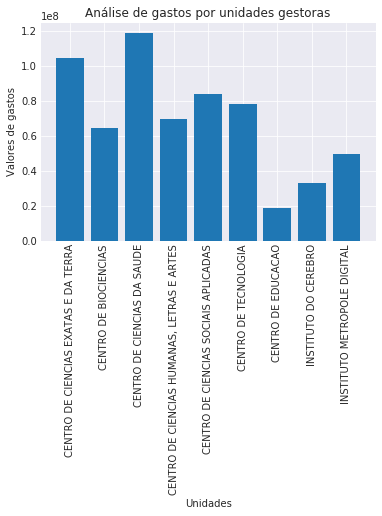

In [15]:
#Criação do gráfico relacionando as unidades gestoras com o valor de investimento em cada

#Plot do gráfico
plt.bar(range(len(data_gastos_ok)), data_gastos_ok["valor"], tick_label = data_gastos_ok["nome_unidade"])

#Customização do gráfico

#Associa o título do gráfico
plt.title("Análise de gastos por unidades gestoras")
#Nomeia o eixo x
plt.xlabel("Unidades")
#Nomeia o eixo  y
plt.ylabel("Valores de gastos")
#Rotaciona o nome do eixo x em um angulo de 90º
plt.xticks(rotation = 90)
#Imprime o gráfico
plt.show()



In [103]:
#Construção do grafico de aprovação e reprovação para 2016

#pode ser assim, mas não curti muito não pra ser sincero  acho meio confuso (acho q o eixo y é uma epsecie e poorcentagem)
#acredito que esse grafico fica melhor quando for relacionar gastos com desempenho
#setores = data_grafico3.nome_unidade
xx = ["2016.1","2016.2","2017.1","2017.2"]
#data_grafico3
#for i in data_grafico3:
#        data_grafico3.plot(kind="line", x=xx, y=["2016.1","2016.1_rep"])
print(range(data_grafico3))
z = ["a"]
#for i in data_grafico3:
 ##      if

TypeError: 'DataFrame' object cannot be interpreted as an integer

/home/gabriel/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


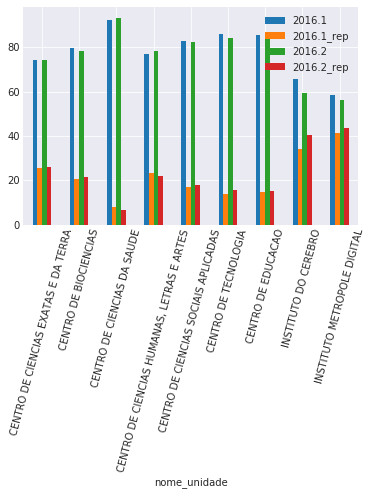

In [12]:
#dêem uma sacada nesse warning
#Gráfico de aprovação de reprovação para o ano de 2016
aux = ['2016.1', '2016.1_rep','2016.2', '2016.2_rep']

data_grafico3.plot( x = 'nome_unidade', y = aux, kind = 'bar')

plt.xticks(rotation = 75)

plt.show()

/home/gabriel/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


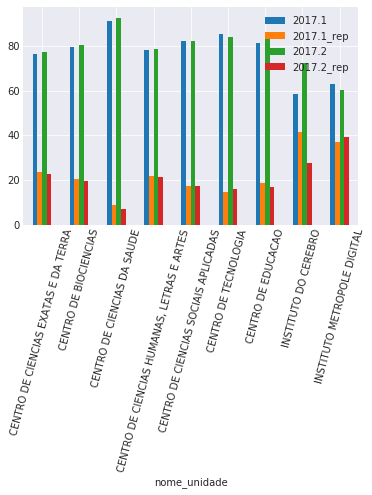

In [14]:
#Gráfico de aprovação de reprovação para o ano de 2017
aux = ['2017.1', '2017.1_rep','2017.2', '2017.2_rep']

data_grafico3.plot( x = 'nome_unidade', y = aux, kind = 'bar')

plt.xticks(rotation = 75)

plt.show()

# 3.1 Relação entre gastos e desempenho

In [55]:
#usem o data_gasto_aprov data_grafico2(ou 3)

#acho q o seaborn pode ser bom nesse tipo cada eixo fica pra gastos-desempenho 

#Estou fazendo o README 

#Se acharem necessários mais paragrafos avisem !!!